In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
import altair
import seaborn
RANDOM_SEED = 511
rng = np.random.default_rng(RANDOM_SEED)
seaborn.set_theme(style="darkgrid")
altair.renderers.enable('mimetype')
db_url = os.getenv('DB_URL')

In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
from lib import adjust_pairplot_axes

In [3]:

sql = """
select 
    zip_code,
    neighborhood_name,
    borough_name,
    CASE WHEN is_harlem THEN 'Harlem' ELSE 'Rest of NYC' END AS is_harlem,

    avg_daily_enrollment_2010 AS "Daily Avg OTP Enrollment (2010)",
    avg_daily_enrollment_2010::FLOAT / (SUM(avg_daily_enrollment_2010) OVER ())
        AS "Fraction of Daily Avg OTP Enrollment (2010)",

    avg_daily_enrollment_2015 AS "Daily Avg OTP Enrollment (2015)",
    avg_daily_enrollment_2015::FLOAT / (SUM(avg_daily_enrollment_2015) OVER ())
        AS "Fraction of Daily Avg OTP Enrollment (2015)",

    avg_daily_enrollment_2019 AS "Daily Avg OTP Enrollment (2019)",
    avg_daily_enrollment_2019::FLOAT / (SUM(avg_daily_enrollment_2019) OVER ())
        AS "Fraction of Daily Avg OTP Enrollment (2019)",
    
    total_admissions_3_2019 AS "OTP Admissions (2019)",
    total_admissions_3_2019::FLOAT / (SUM(total_admissions_3_2019) OVER ())
        AS "Fraction of OTP Admissions (2019)",

    otp_capacity AS "OTP Capacity (2019)",
    otp_capacity::FLOAT / (SUM(otp_capacity) OVER ())
        AS "Fraction of OTP Capacity (2019)",

    patient_admissions_3_2019 AS "Estimated OTP Patients (2019)",
    patient_admissions_3_2019::FLOAT / (SUM(patient_admissions_3_2019) OVER ())
        AS "Estimated Fraction of OTP Patients (2019)"
    
from zip_code_otp_analysis
"""
zip_df = pd.read_sql(sql, con=db_url)

for c in [
    'zip_code',
    'neighborhood_name',
    'borough_name',
    'is_harlem'
]:
    zip_df[c] = pd.Categorical(zip_df[c])

zip_df = zip_df.set_index('zip_code')
zip_df.head(3).T


zip_code,10001,10002,10003
neighborhood_name,Chelsea and Clinton,Lower East Side,Lower East Side
borough_name,Manhattan,Manhattan,Manhattan
is_harlem,Rest of NYC,Rest of NYC,Rest of NYC
Daily Avg OTP Enrollment (2010),803.0,1316.0,NaN
Fraction of Daily Avg OTP Enrollment (2010),0.023781,0.038974,NaN
Daily Avg OTP Enrollment (2015),820.0,1339.0,NaN
Fraction of Daily Avg OTP Enrollment (2015),0.023374,0.038169,NaN
Daily Avg OTP Enrollment (2019),831.0,1263.0,NaN
Fraction of Daily Avg OTP Enrollment (2019),0.028501,0.043317,NaN
OTP Admissions (2019),601.0,725.0,NaN


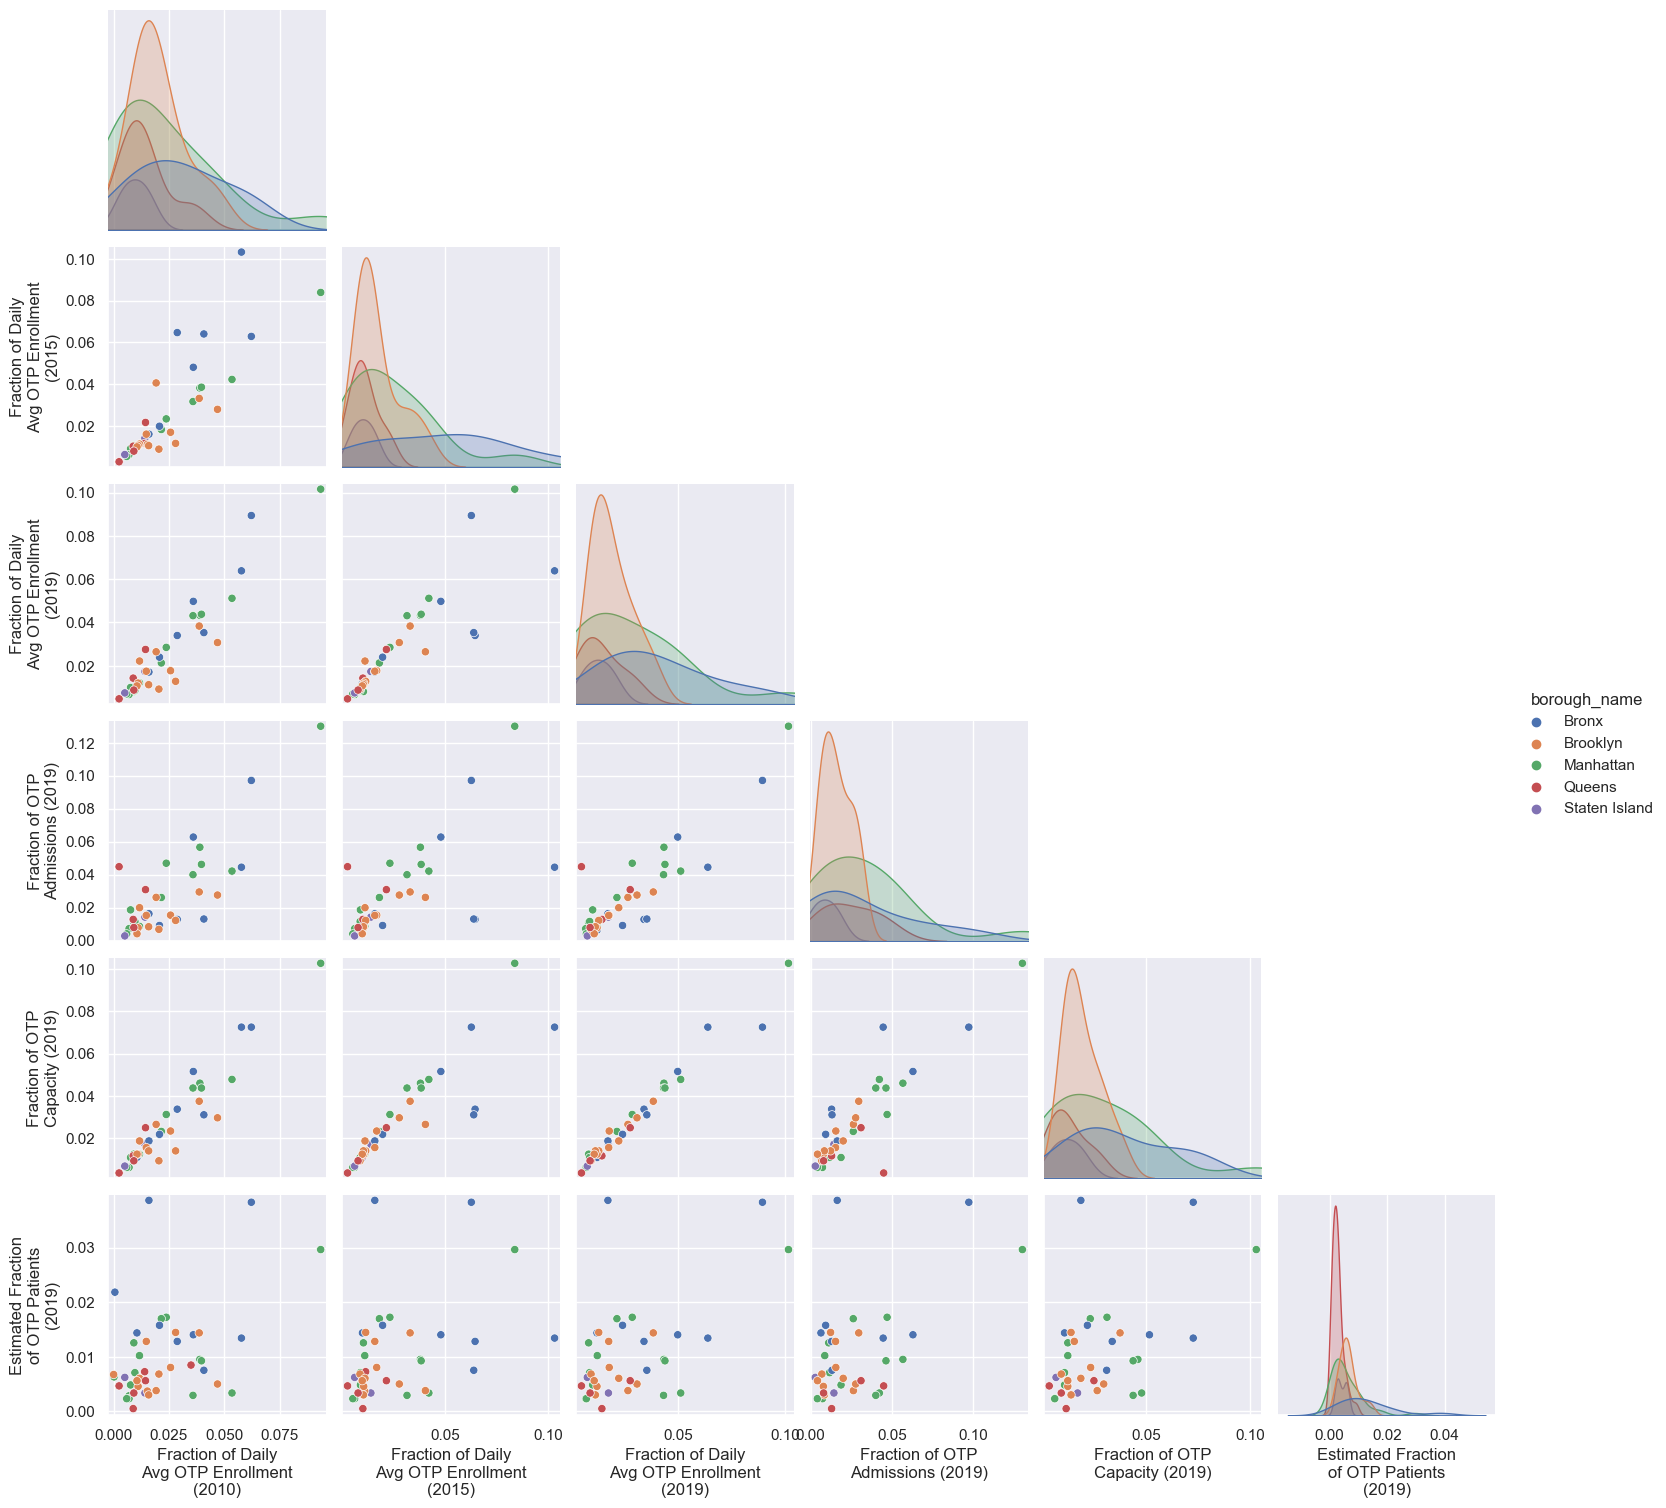

In [4]:
measures = [c for c in zip_df.columns if 'Fraction' in c]
p = seaborn.pairplot(
    zip_df[['borough_name'] + measures], 
    hue='borough_name',
    corner=True
);

adjust_pairplot_axes(zip_df, measures, p)

In [5]:
by_borough = (zip_df
    .drop(columns=['is_harlem', 'neighborhood_name'])
    .groupby('borough_name')
    .sum()
)
by_borough

,Daily Avg OTP Enrollment (2010),Fraction of Daily Avg OTP Enrollment (2010),Daily Avg OTP Enrollment (2015),Fraction of Daily Avg OTP Enrollment (2015),Daily Avg OTP Enrollment (2019),Fraction of Daily Avg OTP Enrollment (2019),OTP Admissions (2019),Fraction of OTP Admissions (2019),OTP Capacity (2019),Fraction of OTP Capacity (2019),Estimated OTP Patients (2019),Estimated Fraction of OTP Patients (2019)
borough_name,,,,,,,,,,,,
Bronx,9230.0,0.273352,13644.0,0.388928,9489.0,0.325445,3358.0,0.262426,10015.0,0.313380,3719.0,0.322242
Brooklyn,8723.0,0.258337,7324.0,0.208774,6093.0,0.208972,2225.0,0.173882,6850.0,0.214344,2748.0,0.238108
Manhattan,12330.0,0.365160,11493.0,0.327613,11237.0,0.385396,5756.0,0.449828,12732.0,0.398398,2677.0,0.231956
Queens,2834.0,0.083931,1904.0,0.054274,1614.0,0.055355,1237.0,0.096671,1591.0,0.049784,1823.0,0.157959
Staten Island,649.0,0.019221,716.0,0.020410,724.0,0.024831,220.0,0.017193,770.0,0.024094,574.0,0.049736


''

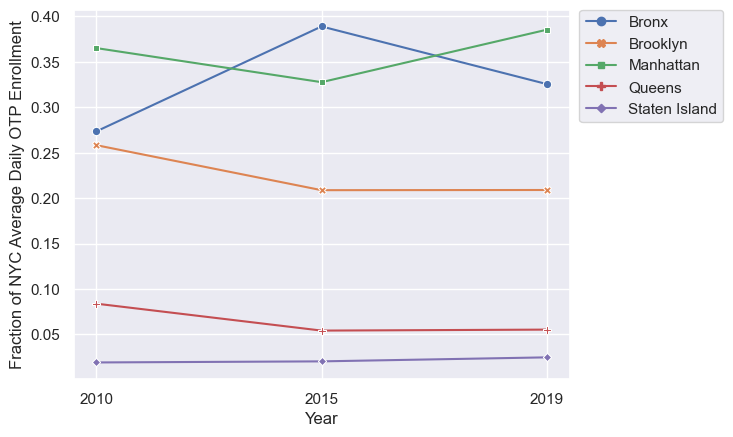

In [6]:
yrs = ('2010', '2015', '2019')

fractional_enrollment_over_time_by_borough = (
    by_borough[[f'Fraction of Daily Avg OTP Enrollment ({yr})' for yr in yrs]]
        .rename(columns={
            f'Fraction of Daily Avg OTP Enrollment ({yr})': yr
            for yr in yrs
        })
        .T
)
ax = seaborn.lineplot(
    data=fractional_enrollment_over_time_by_borough, 
    markers=True, dashes=False,
    
)
ax.set_xlabel('Year')
ax.set_ylabel('Fraction of NYC Average Daily OTP Enrollment')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
;

In [7]:
yrs = ('2010', '2015', '2019')

enrollment_over_time_by_borough = (
    by_borough[[f'Daily Avg OTP Enrollment ({yr})' for yr in yrs]]
        .rename(columns={
            f'Daily Avg OTP Enrollment ({yr})': yr
            for yr in yrs
        })
        .T
)
enrollment_over_time_by_borough_long = enrollment_over_time_by_borough.unstack().reset_index()
enrollment_over_time_by_borough_long = enrollment_over_time_by_borough_long.rename(columns={
    'borough_name': 'Borough Name',
    enrollment_over_time_by_borough_long.columns[1]: 'Year',
    enrollment_over_time_by_borough_long.columns[2]: 'Avg Daily Enrollment'
})

(altair.Chart(enrollment_over_time_by_borough_long)
    .properties(width=550)
    .mark_line(point=altair.OverlayMarkDef())
    .encode(
        x='Year',
        y='Avg Daily Enrollment',
        color='Borough Name',
        tooltip=list(enrollment_over_time_by_borough_long.columns)
    )
    .interactive()
)

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


## Enrollment vs Overdose Deaths, by year

In [8]:

sql = """
with enrollment as (
    select
        p.borough_name,
        c.year,
        SUM(c.avg_daily_enrollment) AS enrollment
    from chan_foil c
        join programs as p using (program_number)
    group by 1, 2
)
select
    borough_name,
    year,
    enrollment AS "OTP Enrollment",
    ny_county_od_trend.deaths AS "Opioid Overdose Deaths",
    rate_per_100k AS "Opioid Overdose Deaths/100k",
    100000 * enrollment / total_population AS "OTP Enrollment/100k"
from enrollment AS e
    full outer join ny_county_od_trend using (borough_name, year)
where ny_county_od_trend.is_nyc
order by 1, 2
"""
borough_df = pd.read_sql(sql, con=db_url)

for c in ['borough_name']:
    borough_df[c] = pd.Categorical(borough_df[c])

borough_df.head(7)

,borough_name,year,OTP Enrollment,Opioid Overdose Deaths,Opioid Overdose Deaths/100k,OTP Enrollment/100k
0,Bronx,2010,14731.0,71,5.1,1062.0
1,Bronx,2011,NaN,93,6.7,NaN
2,Bronx,2012,NaN,109,7.7,NaN
3,Bronx,2013,NaN,105,7.4,NaN
4,Bronx,2014,NaN,102,7.1,NaN
5,Bronx,2015,18286.0,175,12.2,1270.0
6,Bronx,2016,NaN,266,18.4,NaN


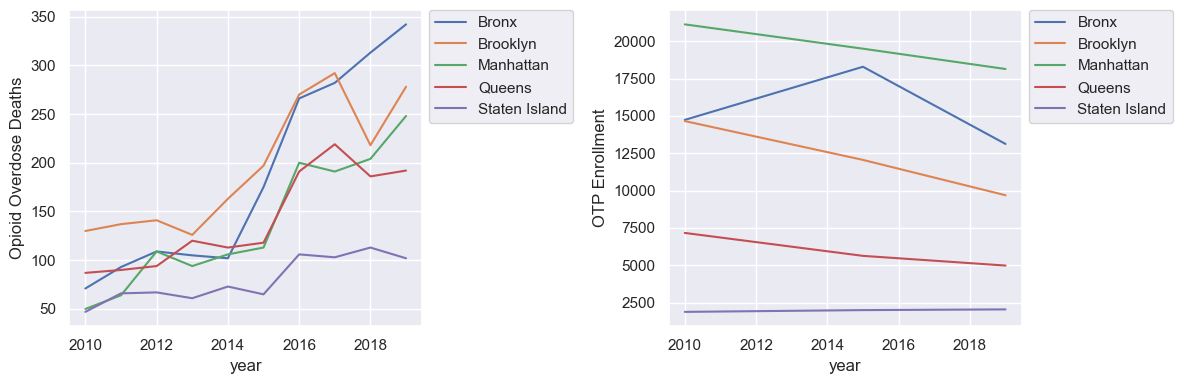

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
seaborn.lineplot(
    borough_df,
    x='year',
    y='Opioid Overdose Deaths',
    hue='borough_name',
    ax=ax1
)
ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
seaborn.lineplot(
    borough_df[~borough_df['OTP Enrollment'].isnull()],
    x='year',
    y='OTP Enrollment',
    hue='borough_name',
    ax=ax2
)
ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()

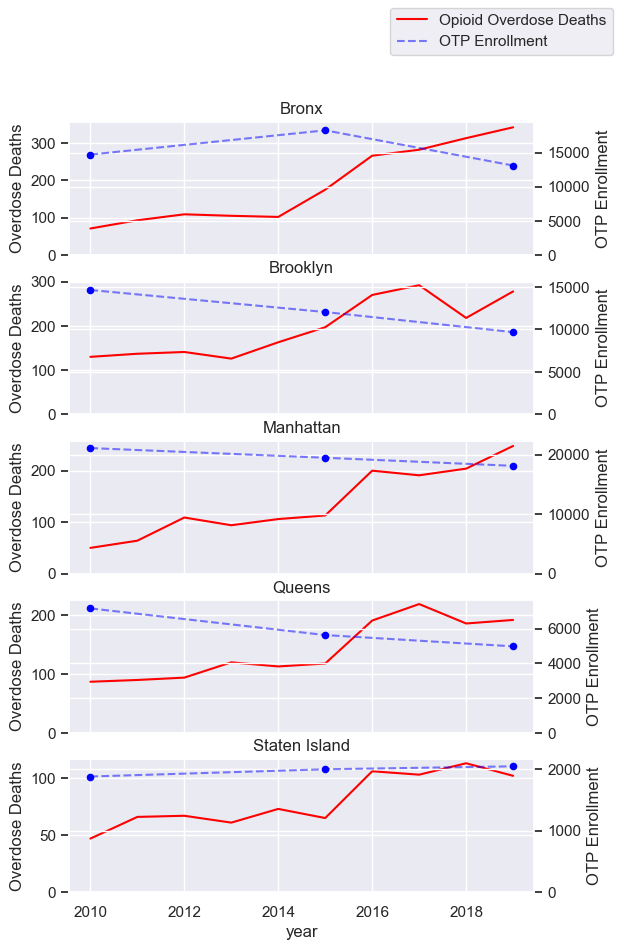

In [10]:
boroughs = list(borough_df['borough_name'].unique())
fig, axes = plt.subplots(len(boroughs), 1, sharex=True, sharey=False, figsize=(6, 10))
axes2 = [ax.twinx() for ax in axes]
# axes2[0].get_shared_y_axes().join(*axes2)
for (i, (b, ax1, ax2)) in enumerate(zip(boroughs, axes, axes2)):
    borough = borough_df[borough_df['borough_name'] == b]
    borough.plot(kind='line', x='year', y='Opioid Overdose Deaths', ax=ax1, color='red', legend=False)
    borough[~borough['OTP Enrollment'].isnull()].plot(
        kind='line', x='year', y='OTP Enrollment', ax=ax2, color='blue', style='--', alpha=0.5, legend=False)
    borough.plot(kind='scatter', x='year', y='OTP Enrollment', ax=ax2, color='blue', legend=False)
    ax1.set_ylabel('Overdose Deaths')
    ax1.set_title(b)
    ax1.set_ylim((0, ax1.get_ylim()[1]))
    ax2.set_ylim((0, ax2.get_ylim()[1] * 1.05))
    # if i != len(boroughs) - 1:
    #     ax2.set_ylabel(None)

handles = axes[0].get_legend_handles_labels()[0] + axes2[0].get_legend_handles_labels()[0]
labels = axes[0].get_legend_handles_labels()[1] + axes2[0].get_legend_handles_labels()[1]
fig.legend(handles, labels, loc='upper right')


In [11]:
enrollment_df = borough_df[~borough_df['OTP Enrollment'].isnull()]
# enrollment_df = borough_df[borough_df.year.isin([2010, 2019])]
enrollment_df

,borough_name,year,OTP Enrollment,Opioid Overdose Deaths,Opioid Overdose Deaths/100k,OTP Enrollment/100k
0,Bronx,2010,14731.0,71,5.1,1062.0
5,Bronx,2015,18286.0,175,12.2,1270.0
9,Bronx,2019,13121.0,342,23.9,916.0
10,Brooklyn,2010,14652.0,130,5.2,583.0
15,Brooklyn,2015,12053.0,197,7.6,462.0
19,Brooklyn,2019,9688.0,278,10.8,375.0
20,Manhattan,2010,21123.0,50,3.1,1329.0
25,Manhattan,2015,19496.0,113,6.9,1190.0
29,Manhattan,2019,18136.0,248,15.2,1111.0
30,Queens,2010,7165.0,87,3.9,320.0


In [14]:
(altair.Chart(enrollment_df)
    .mark_line(point=altair.OverlayMarkDef(color='year'))
    .encode(
        y='OTP Enrollment',
        x='Opioid Overdose Deaths',
        color='borough_name',
        tooltip=list(enrollment_df.columns)
    )
    .interactive()
)

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [15]:
def normalize_to_2010(g):
    g = g.set_index('year')[['OTP Enrollment', 'Opioid Overdose Deaths']]
    return g / g.loc[2010]

enrollment_fractions_df = (
    enrollment_df[enrollment_df.year.isin([2010, 2019])]
    .groupby('borough_name')
    .apply(normalize_to_2010)
    .reset_index()
    .rename(columns={
        'OTP Enrollment': 'OTP Enrollment (Relative to 2010)',
        'Opioid Overdose Deaths': 'Opioid Overdose Deaths (Relative to 2010)',
    })
)
(altair.Chart(enrollment_fractions_df)
    .mark_line(point=altair.OverlayMarkDef())
    .encode(
        y='OTP Enrollment (Relative to 2010)',
        x='Opioid Overdose Deaths (Relative to 2010)',
        color='borough_name',
        tooltip=list(enrollment_fractions_df.columns)
    )
    .interactive()
)

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html
